In [1]:
%load_ext autoreload
%autoreload 2

# Ejemplo para Generar Curva de Luz de WASP-43b

En este ejemplo veremos como usar las rutinas incluidas en transitos_dha1001 para reducir los datos de observaciones de un tránsito de WASP-43b hechas con el telescopio MAS500 en el observatorio El Sauce. 

Este ejemplo le podrá ser de gran utilidad para reducir otras observaciones hechas con el mismo telescopio y generar la curva de luz de otro tránsito. 

En general dividirémos las acciones en tres partes: 

* Reducción de los datos
* Medición de la fotometría
* Generación de la curva de luz

Usando la curva de luz usted podrá medir, por ejemplo, el tamaño del planeta WASP-43b en relación al tamaño de su estrella, WASP-43. 

Usted podrá encontrar las observaciones de WASP-43 hechas con el telescopio MAS500 [aquí](https://www.astro.udp.cl/~rjassef/DHA1001/WASP-43). Baje las observaciones y pongalas en el directorio wasp43_raw. 

In [2]:
from transitos_dha1001 import *

In [3]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.io import fits

## Parte I - Reducción

Para reducir los datos, primero vamos a necesitar crear imagenes de calibración. Estas están basadas en calibraciones tomadas la misma noche, de ser posible, o en noches cercanas en otro caso. 

#### a) Bias

La primera calibración que crearemos es la que se llama Bias. Una imagen de bias corresponde a una lectura de la cámara sin haber abierto el obturador y con tiempo de exposición de 0 segundos (es decir, sin exponer el CCD). Dado que el proceso de lectura del CCD es imperfecto, esta imagen nos muestra exáctamente cuál es el patrón de esta imperfección. 

Para crear la imagen de calibración que vamos a usar, y que llamaremos MasterBias.fits, vamos a combinar 10 imagenes de bias tomadas immediatamente después de que se hicieron las observaciones de WASP-43. 

Estas imagenes corresponden a las que tienen los números 55 a 64. 

In [4]:
#Esta instrucción genera una lista de los nombres de las imágenes de bias 
#que vamos a combinar.
imagenes_bias = []
for i in range(55,65):
    imagenes_bias.append("{0:08d}.Bias.fit".format(i))
print(imagenes_bias)

['00000055.Bias.fit', '00000056.Bias.fit', '00000057.Bias.fit', '00000058.Bias.fit', '00000059.Bias.fit', '00000060.Bias.fit', '00000061.Bias.fit', '00000062.Bias.fit', '00000063.Bias.fit', '00000064.Bias.fit']


In [5]:
#Esta rutina combina las 10 imágenes de bias. Específicamente, en cada pixel
#calcula la mediana de las 10 imágenes.
crear_masterbias(imagenes_bias, nombre_bias="MasterBias.fits",
                 directorio_imagenes_originales="wasp43_raw",
                 directorio_imagenes_reducidas="wasp43_red")

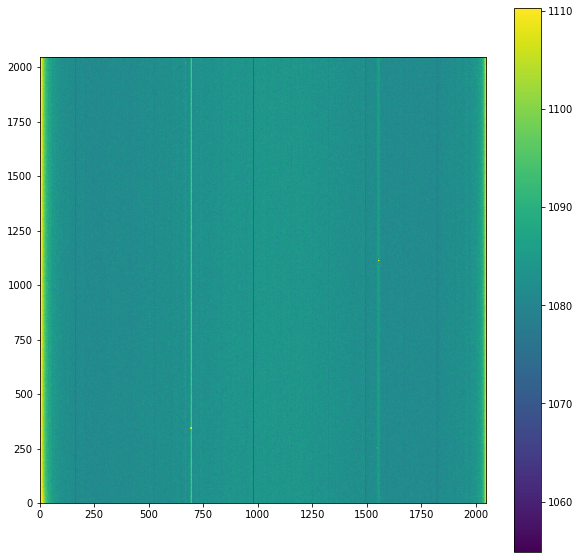

In [6]:
#Ahora vamos a cargar la imágen y la vamos a ver para revisar que no
#haya ningún problema. Usted también la puede abrir usando la herramienta
#DS9 desde la línea de comando. 
master_bias = fits.open("wasp43_red/MasterBias.fits")
norm = ImageNormalize(master_bias[0].data, interval=ZScaleInterval())
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(master_bias[0].data, origin='lower', norm=norm)
fig.colorbar(im)

#### b) Dark

Además de los problemas de lectura evidenciados por el bias, las cámara CCD también tienen un problema que se le llama *corriente oscura*. La corriente oscura consiste en electrones que aleatoriamente entran a los pixeles sin corresponder a un fotón, y dependen de cuánto tiempo de exposición tengan las imágenes. 

Nuestra imagen de calibración, a la que llamaremos **Dark** será generada combinando 10 imágenes de calibración obtenidas inmediatamente después de las observaciones de WASP-43. Estas fueron obtenidas usando el mismo tiempo de exposición que las imágenes de ciencia, es decir, 120 segundos, pero sin abrir el obturador. Como no se abrió el obturador de la cámara, sabemos que todos los electrones detectados, entonces, corresponden a la corriente oscura de la cámara y no a fotones reales. Dado que estas imágenes de calibración también van a tener problemas de lectura, al igual que todas las imágenes tomadas por esta cámara, vamos a necesitar el Bias generado en el paso anterior para corregir nuestras imágenes de corriente oscura. 

In [7]:
#Esta instrucción genera una lista de los nombres de las imágenes de bias 
#que vamos a combinar.
imagenes_dark = []
for i in range(45,55):
    imagenes_dark.append("{0:08d}.Dark.fit".format(i))
print(imagenes_dark)

['00000045.Dark.fit', '00000046.Dark.fit', '00000047.Dark.fit', '00000048.Dark.fit', '00000049.Dark.fit', '00000050.Dark.fit', '00000051.Dark.fit', '00000052.Dark.fit', '00000053.Dark.fit', '00000054.Dark.fit']


In [10]:
crear_masterdark(imagenes_dark, nombre_dark="MasterDark.fits",
                 nombre_bias="MasterBias.fits",
                 directorio_imagenes_originales="wasp43_raw", 
                 directorio_imagenes_reducidas="wasp43_red")

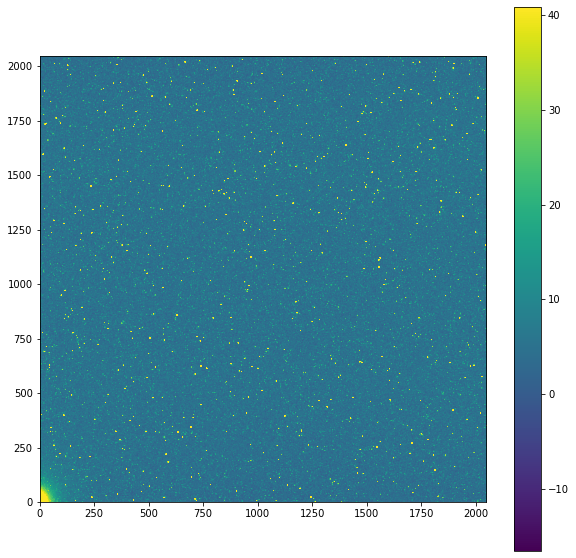

In [11]:
#Ahora vamos a cargar la imágen y la vamos a ver para revisar que no
#haya ningún problema. Usted también la puede abrir usando la herramienta
#DS9 desde la línea de comando. 
master_dark = fits.open("wasp43_red/MasterDark.fits")
norm = ImageNormalize(master_dark[0].data, interval=ZScaleInterval())
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(master_dark[0].data, origin='lower', norm=norm)
fig.colorbar(im)

#### c) Flat

La última imágen de calibración que vamos a necesitar es aquella a la que llamamos **Flat**, que corresponde a una imágen de una zona intrínsecamente uniforme, de tal manera que las diferencias entre los pixeles representan diferencias de sensibilidad entre los pixeles de la cámara. Estas imágenes de calibración típicamente se obtienen observando el cielo justo después del atardecer, cuando aún hay brillo del Sol, pero el Sol ya está bajo el horizonte. Estas imágenes son sacadas en el mismo filtro en que se hacen las observaciones de ciencia, y necesitan se corregidas por el Bias y el Dark. 

In [12]:
#Esta instrucción genera una lista de los nombres de las imágenes de bias 
#que vamos a combinar.
imagenes_flat = []
for i in range(1,6):
    imagenes_flat.append("FLAT_sloan_r_B22-{0:03d}.fit".format(i))
print(imagenes_flat)

['FLAT_sloan_r_B22-001.fit', 'FLAT_sloan_r_B22-002.fit', 'FLAT_sloan_r_B22-003.fit', 'FLAT_sloan_r_B22-004.fit', 'FLAT_sloan_r_B22-005.fit']


In [14]:
crear_masterflat(imagenes_flat, 
                 nombre_flat="MasterFlat.fits",
                 nombre_dark="MasterDark.fits",
                 nombre_bias="MasterBias.fits",
                 directorio_imagenes_originales="wasp43_raw",
                 directorio_imagenes_reducidas="wasp43_red")

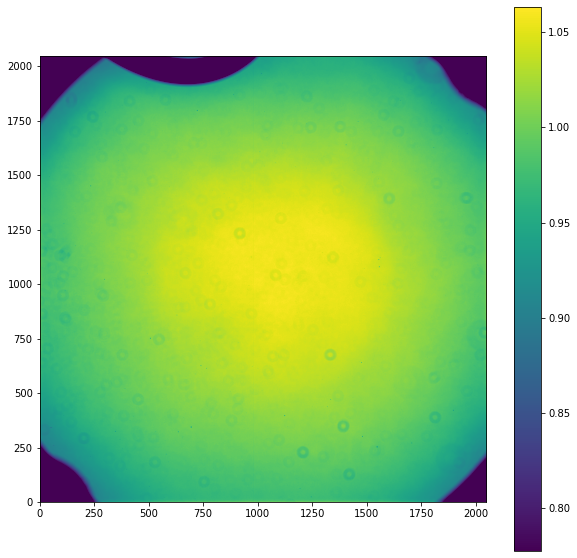

In [15]:
#Ahora vamos a cargar la imágen y la vamos a ver para revisar que no
#haya ningún problema. Usted también la puede abrir usando la herramienta
#DS9 desde la línea de comando. 
master_flat = fits.open("wasp43_red/MasterFlat.fits")
norm = ImageNormalize(master_flat[0].data, interval=ZScaleInterval())
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(master_flat[0].data, origin='lower', norm=norm)
fig.colorbar(im)

#### d) Reducción de las imágenes de Ciencia

Usando nuestras tres imágenes de calibración, **Bias**, **Dark** y **Flat**, vamos a corregir las imperfecciones de la cámara en todas nuestras imágenes de ciencia. Además, vamos a aplicar una rutina de corrección de rayos cósmicos, que son electrones que viajan por el ambiente y quedan atrapados en los pixeles de la cámara. 

In [16]:
#Esta instrucción genera una lista de los nombres de las imágenes de bias 
#que vamos a combinar.
imagenes_ciencia = []
for i in range(4,45):
    imagenes_ciencia.append("{0:08d}.fit".format(i))
print(imagenes_ciencia)

['00000004.fit', '00000005.fit', '00000006.fit', '00000007.fit', '00000008.fit', '00000009.fit', '00000010.fit', '00000011.fit', '00000012.fit', '00000013.fit', '00000014.fit', '00000015.fit', '00000016.fit', '00000017.fit', '00000018.fit', '00000019.fit', '00000020.fit', '00000021.fit', '00000022.fit', '00000023.fit', '00000024.fit', '00000025.fit', '00000026.fit', '00000027.fit', '00000028.fit', '00000029.fit', '00000030.fit', '00000031.fit', '00000032.fit', '00000033.fit', '00000034.fit', '00000035.fit', '00000036.fit', '00000037.fit', '00000038.fit', '00000039.fit', '00000040.fit', '00000041.fit', '00000042.fit', '00000043.fit', '00000044.fit']


In [17]:
reducir_imagenes_ciencia(imagenes_ciencia, prefijo="ciencia",
                         reyeccion_rayos_cosmicos=True,
                         nombre_flat="MasterFlat.fits",
                         nombre_dark="MasterDark.fits",
                         nombre_bias="MasterBias.fits",
                         directorio_imagenes_originales="wasp43_raw", 
                         directorio_imagenes_reducidas="wasp43_red")

Para comparara los efectos de estas correcciones, vamos a ver una imagen antes y después de realizar todas las correcciones. 

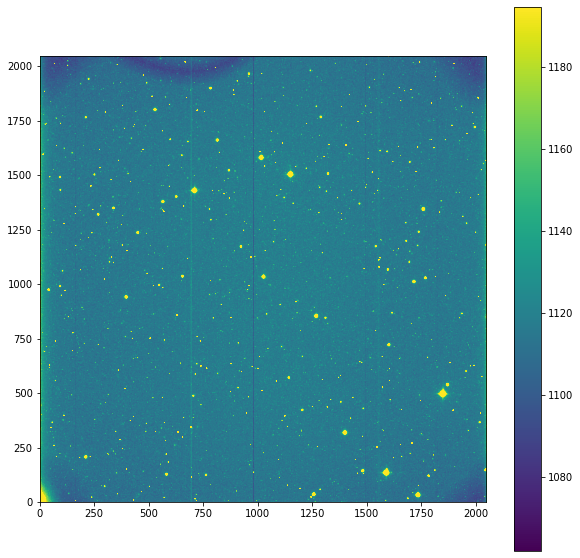

In [18]:
imagen_nocorregida = fits.open("wasp43_raw/00000005.fit")
norm = ImageNormalize(imagen_nocorregida[0].data, interval=ZScaleInterval())
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(imagen_nocorregida[0].data, origin='lower', norm=norm)
fig.colorbar(im)

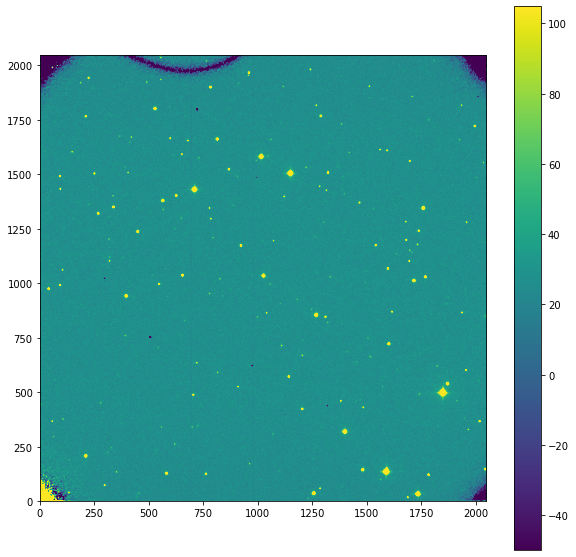

In [21]:
imagen_corregida = fits.open("wasp43_red/ciencia_00000005.fit")
norm = ImageNormalize(imagen_corregida[0].data, interval=ZScaleInterval())
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(imagen_corregida[0].data, origin='lower', norm=norm)
fig.colorbar(im)